# Imported Libraries

In [1]:
import pydicom
import dicom2nifti
import matplotlib.pyplot as plt
import pysera
from nilearn import plotting
import numpy as np
import json
from pprint import pprint
from nilearn import plotting
from pydicom import dcmread, examples
import nibabel as nib
from brainextractor import BrainExtractor
from nilearn import image
import ants

# Dicom metadata inspection

In [2]:
# Reading a DICOM file from a specific path

dcm_data = pydicom.dcmread('dicoms/N2D_0001.dcm')
dcm_data

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 236
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1143.1590429688519720198888333603882344634
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.2.8.3
(0002,0013) Implementation Version Name         SH: 'GDCM 2.8.3'
(0002,0016) Source Application Entity Title     AE: 'gdcmanon'
-------------------------------------------------
(0008,0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1143.1590429688519720198888333603882344634
(0008,0020) Study Date  

In [3]:
dcm_data.dir('Pixel')


['PixelData', 'PixelRepresentation', 'PixelSpacing', 'SamplesPerPixel']

# Convert Dicom files to Nifti (Commented/Disabled)

In [4]:
import subprocess
from pathlib import Path

dicom_dir = Path("dicoms")
output_dir = Path("nifti")
output_dir.mkdir(exist_ok=True)

cmd = [
    "dcm2niix",
    "-b", "y",
    "-o", str(output_dir),
    "-f", "%p_%s", 
    "-x", "y",  
    "-p", "y",
    str(dicom_dir)
]

subprocess.run(cmd)

CompletedProcess(args=['dcm2niix', '-b', 'y', '-o', 'nifti', '-f', '%p_%s', '-x', 'y', '-p', 'y', 'dicoms'], returncode=0)

# Glass Brain Plotting using nilearn

C:\Users\Rafid\AppData\Local\Temp\ipykernel_12280\2377299075.py:4: UserWarning: Casting data from int32 to float32
  plotting.plot_glass_brain(nifti_img, threshold=3)


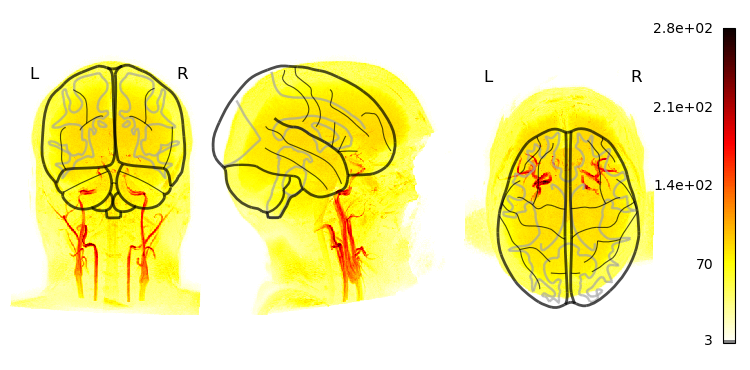

In [5]:
# Plot a 2D slice with anatomical information
nifti_img='nifti/anat-T1w_401.nii'
#plotting.plot_anat(nifti_img, display_mode='ortho',title="Anatomical Slice")
plotting.plot_glass_brain(nifti_img, threshold=3)

#plt.show()


# Nifti sidecar file inspection

In [6]:


with open("nifti/anat-T1w_401.json") as f:
    sidecar = json.load(f)

pprint(sidecar)


{'AcquisitionNumber': 1,
 'AcquisitionTime': '13:25:18.000000',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20250505',
 'ImageOrientationPatientDICOM': [0.999032,
                                  -0.0217884,
                                  0.0382096,
                                  0.0265195,
                                  0.991414,
                                  -0.128044],
 'ImageType': ['DERIVED', 'SECONDARY'],
 'ManufacturersModelName': 'nifti2dicom',
 'Modality': 'MR',
 'ProtocolName': 'anat-T1w',
 'RawImage': False,
 'SeriesDescription': 'anat-T1w',
 'SeriesNumber': 401,
 'SliceThickness': 0.666667,
 'SoftwareVersions': '0.4.11',
 'SpacingBetweenSlices': 0.666667,
 'StudyDescription': 'Hanke_Stadler^0024_transrep'}


# Preprocessing steps

## Plotting Brain (for visual comparison)

C:\Users\Rafid\AppData\Local\Temp\ipykernel_12280\4142714705.py:1: UserWarning: Casting data from int32 to float32
  plotting.plot_img(nifti_img)


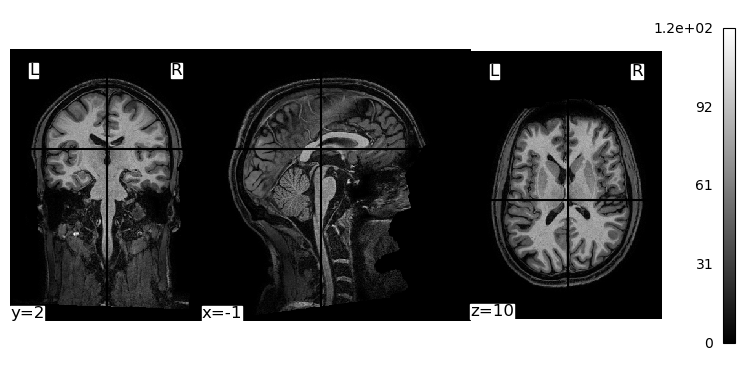

In [7]:


plotting.plot_img(nifti_img)

## Extracting Brain image

In [8]:

# Load the image
input_img = nib.load(nifti_img)
# Create the extractor object and run
bet = BrainExtractor(img=input_img, bt=0.33)
bet.run()
bet.save_mask("nifti/anat-T1w_401_mask.nii")

Initializing...
Parameters: bt=0.330000, d1=20.000000, d2=10.000000, rmin=3.330000, rmax=10.000000


C:\Users\Rafid\anaconda3\Lib\site-packages\brainextractor\main.py:44: UserWarning: The voxels in this image are non-isotropic!                 Brain extraction settings may not be valid!
  warnings.warn(


tmin: 0.000000, t2: 0.000000, t: 7.200000, t98: 72.000000, tmax: 278.000000
Center-of-Mass: [132.80645179 173.59596214 206.94190145]
Head Radius: 144.881070
Median within Head Radius: 26.000000
Initializing surface...
Brain extractor initialization complete!
Running surface deformation...
Iteration: 999
Complete.


### Plotting Brain Mask

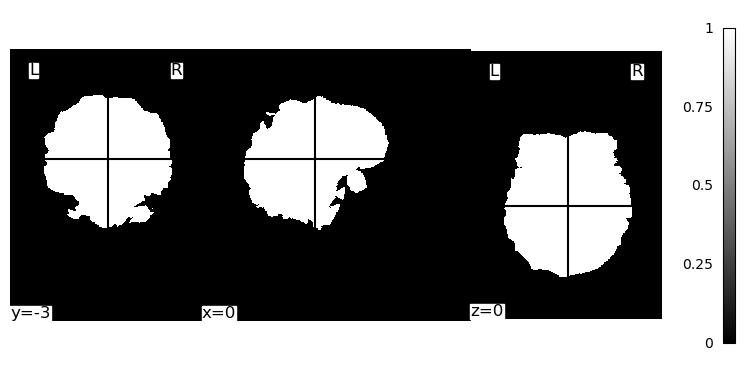

In [9]:
plotting.plot_img('nifti/anat-T1w_401_mask.nii')


### Acquiring Brain Image from Mask

In [10]:

# Load original image and mask

mask_nii = nib.load("nifti/anat-T1w_401_mask.nii")

img = input_img.get_fdata()
mask = mask_nii.get_fdata()

# Apply mask
brain = img * mask

# Save skull-stripped brain image
brain_nii = nib.Nifti1Image(brain, input_img.affine, input_img.header)
nib.save(brain_nii, "nifti/brain_stripped.nii")

### Plotting Extracted Brain

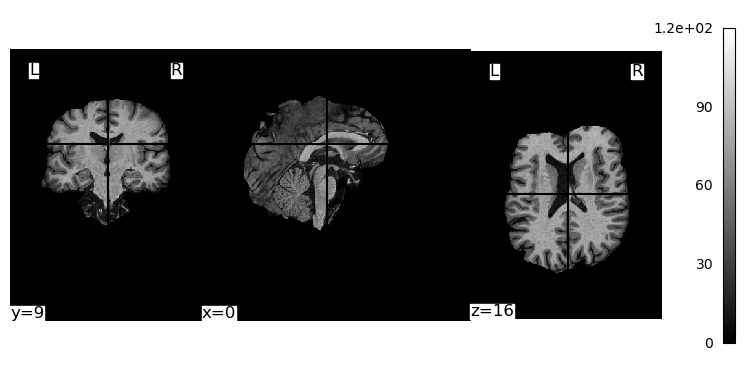

In [11]:
plotting.plot_img('nifti/brain_stripped.nii')


In [12]:

# Input and output paths
input_nii = brain_nii
output_nii = "nifti/brain_denoised.nii"

# Apply Gaussian smoothing (choose FWHM as needed, e.g., 2–6 mm)
denoised_img = image.smooth_img(input_nii, fwhm=1.5)

# Save result
denoised_img.to_filename(output_nii)

print("Denoised file saved:", output_nii)

Denoised file saved: nifti/brain_denoised.nii


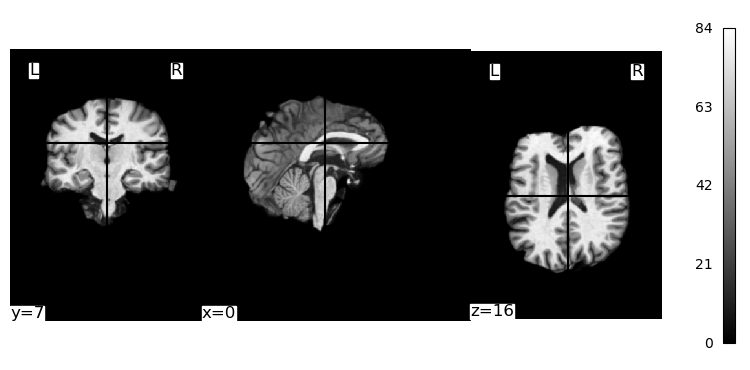

In [13]:
viewer=plotting.plot_img(denoised_img)


# Radiomics Calculation

In [14]:

# Process single image-mask pair
result = pysera.process_batch(
    image_input="nifti/brain_denoised.nii",
    mask_input="nifti/anat-T1w_401_mask.nii",
    output_path="./results"
)

print(f"Success: {result['success']}")
print(f"Features extracted: {result['features_extracted']}")
print(f"Processing time: {result['processing_time']:.2f} seconds")

2025-12-08 12:04:22,007 - INFO - Starting pysera radiomics processing
2025-12-08 12:04:22,043 - INFO - Checking file: nifti\brain_denoised.nii
2025-12-08 12:04:22,044 - INFO - File nifti\brain_denoised.nii detected as NIFTI by extension.
2025-12-08 12:04:22,045 - INFO - Using single image file: nifti/brain_denoised.nii
2025-12-08 12:04:22,046 - INFO - Checking file: nifti\anat-T1w_401_mask.nii
2025-12-08 12:04:22,046 - INFO - File nifti\anat-T1w_401_mask.nii detected as NIFTI by extension.
2025-12-08 12:04:22,047 - INFO - Using single mask file: nifti/anat-T1w_401_mask.nii
2025-12-08 12:04:22,047 - INFO - Processing 1 image-mask pairs
2025-12-08 12:04:22,048 - INFO - Processing sequentially
2025-12-08 12:04:22,049 - INFO - Checking file: nifti\brain_denoised.nii
2025-12-08 12:04:22,049 - INFO - File nifti\brain_denoised.nii detected as NIFTI by extension.
2025-12-08 12:04:22,050 - INFO - Checking file: nifti\anat-T1w_401_mask.nii
2025-12-08 12:04:22,050 - INFO - File nifti\anat-T1w_401

Success: True
Features extracted:             PatientID                 ROI  img_dim_x_init_img  \
0  brain_denoised.nii  label_1.0_lesion_1                 274   

   img_dim_y_init_img  img_dim_z_init_img  vox_dim_x_init_img  \
0                 384                 384                 0.7   

   vox_dim_y_init_img  vox_dim_z_init_img  mean_int_init_img  \
0               0.667               0.667              6.114   

   min_int_init_img  ...  ngl_hdhge_2D  ngl_glnu_2D  ngl_glnu_norm_2D  \
0               0.0  ...    342.688603  8602.893378          0.389223   

   ngl_dcnu_2D  ngl_dcnu_norm_2D  ngl_dcperc_2D  ngl_gl_var_2D  ngl_dc_var_2D  \
0  8614.899918          0.355059            1.0        0.54496       2.482526   

   ngl_dc_entr_2D  ngl_dc_energy_2D  
0        3.439997          0.153963  

[1 rows x 211 columns]
Processing time: 340.92 seconds


# Cortical Thickness Calculation

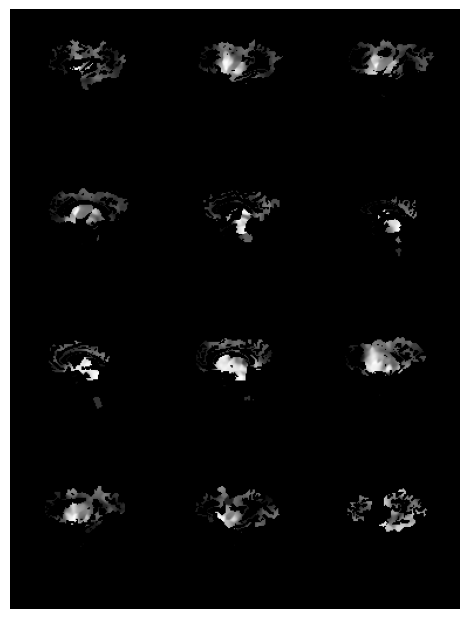

In [15]:


# Load your NIfTI file
img = ants.image_read("nifti/brain_denoised.nii", dimension=3)

# Optional: resample to speed up computation (adjust size if needed)
img_resampled = ants.resample_image(img, (128, 128, 128), use_voxels=True, interp_type=0)

# Create a brain mask
mask = ants.get_mask(img_resampled)

# Segment the brain into 3 tissues (CSF, GM, WM)
segs = ants.kmeans_segmentation(img_resampled, k=3, kmask=mask)

# Compute cortical thickness using Kelly-Kapowski
thick = ants.kelly_kapowski(
    s=segs['segmentation'],             # Segmentation labels
    g=segs['probabilityimages'][1],     # Gray matter probability
    w=segs['probabilityimages'][2],     # White matter probability
    its=45,                             # Number of iterations
    r=0.5,                              # Regularization
    m=1                                 # Maximum thickness allowed
)

# Save the cortical thickness map
ants.image_write(thick, "nifti/brain_cortical_thickness.nii")

# visualize
thick.plot()


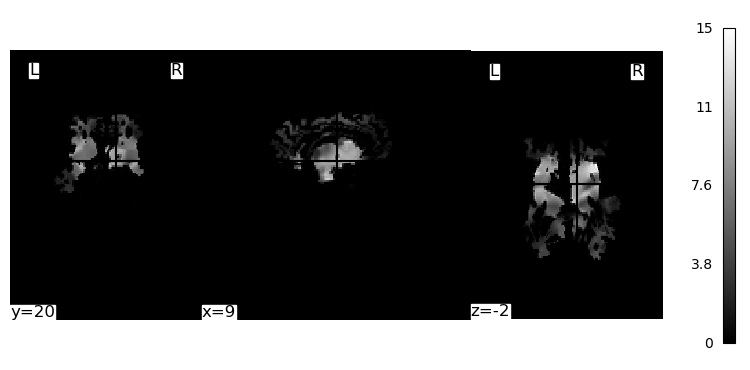

In [16]:
plotting.plot_img('nifti/brain_cortical_thickness.nii')


In [17]:
# Convert the ANTs image to a NumPy array
thick_array = thick.numpy()

# Optional: mask out non-brain voxels (e.g., where thickness=0)
thick_array_masked = thick_array[thick_array > 0]

# Calculate summary statistics
mean_thickness = np.mean(thick_array_masked)
median_thickness = np.median(thick_array_masked)
max_thickness = np.max(thick_array_masked)
min_thickness = np.min(thick_array_masked)

print(f"Mean cortical thickness: {mean_thickness:.3f}")
print(f"Median cortical thickness: {median_thickness:.3f}")
print(f"Max cortical thickness: {max_thickness:.3f}")
print(f"Min cortical thickness: {min_thickness:.3f}")

Mean cortical thickness: 4.310
Median cortical thickness: 3.570
Max cortical thickness: 17.370
Min cortical thickness: 0.251
